## Description:

This file contains:
* data pre-processing (i.e. fill na, scaling, normalizing feature values)
* feature selection (selecting non-correlated features then applying formal feature-selection methods)
* LGBM (feature selected, imbalanced data)
* XGB (feature selected, imbalanced data)
* Balancing dataset via combined sampling

In [1]:
'''Helper''' 
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
import numpy as np
import joblib

'''Feature Selection'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (SelectFromModel, 
                                       SelectKBest)
from BorutaShap import BorutaShap
import lightgbm as lgb

'''Pre-processing'''
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import (RandomOverSampler, 
                                    SVMSMOTE)

from sklearn.metrics import (classification_report, 
                             plot_confusion_matrix, 
                             fbeta_score, 
                             precision_score, 
                             recall_score)

from sklearn.model_selection import (train_test_split,
                                     cross_val_score, 
                                     StratifiedKFold)


'''GCS Utils'''
from gcs_utils import *

import warnings
warnings.filterwarnings('ignore')

SEED=42

In [2]:
BUCKET_NAME = 'bi-subscription-modeling'
BUCKET_FOLDER = 'train-val-data'

file_name = 'train_set_11222021.csv'

download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name) 


file_name = 'val_set_11222021.csv'

download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name) 


file_name = 'test_set_11222021.csv'

download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name)  

In [2]:
# read training, val, test sets

train_df = pd.read_csv("train_set_11222021.csv")

print(train_df.shape)
print(train_df.subscription_status.value_counts())

val_df = pd.read_csv("val_set_11222021.csv")
print(val_df.shape)

test_df = pd.read_csv("test_set_11222021.csv")
print(test_df.shape)

(355555, 619)
0    286992
1     68563
Name: subscription_status, dtype: int64
(76191, 619)
(76191, 619)


In [3]:
val_df.equals(test_df)

False

In [4]:
train_df.tail()

,session_pvs_mean,session_pvs_median,session_top_mean,session_top_median,bounce_rate,content_views_rate,rf_content_aggregators,rf_direct,rf_fbia,rf_newsletter,...,minute_51_top,minute_52_top,minute_53_top,minute_54_top,minute_55_top,minute_56_top,minute_57_top,minute_58_top,minute_59_top,subscription_status
355550,1.0,1.0,72.0,72.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
355551,1.0,1.0,97.0,97.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
355552,1.0,1.0,95.0,95.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
355553,2.4,2.0,147.8,51.3,0.2,0.9,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.5,0.0,0.0,131.5,0.0,1
355554,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


**Treatment 1** - Drop correlated features

In [6]:
# Create correlation matrix of the entire dataframe
corr_matrix = train_df.corr().abs()

# Select upper triangle of correlation matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(len(to_drop)) # 4 mins

print(to_drop)

['session_pvs_median', 'session_top_median', 't2_auto_type_pvs', 't2_college_education_pvs', 't2_computing_pvs', 't2_diseases_and_conditions_pvs', 't2_email_pvs', 't2_law_pvs', 't2_politics_pvs', 't2_real_estate_buying_and_selling_pvs', 't2_travel_type_pvs', 't2_video_game_genres_pvs', 'pc_money_pvs', 'ps_crypto_and_blockchain_pvs', 'ps_games_pvs', 'ps_travel_pvs', 'weekday_pvs', 'business_hours_pvs']


In [5]:
to_drop = ['session_pvs_median', 'session_top_median', 't2_auto_type_pvs', 't2_college_education_pvs', 't2_computing_pvs', 
           't2_diseases_and_conditions_pvs', 't2_email_pvs', 't2_law_pvs', 't2_politics_pvs', 't2_real_estate_buying_and_selling_pvs', 
           't2_travel_type_pvs', 't2_video_game_genres_pvs', 'pc_money_pvs', 'ps_crypto_and_blockchain_pvs', 'ps_games_pvs', 
           'ps_travel_pvs', 'weekday_pvs', 'business_hours_pvs']

In [6]:
train_df.drop(to_drop, axis=1, inplace=True)

print("Whole df shape: ", train_df.shape)

Whole df shape:  (355555, 601)


**Treatment 2** - Feature Select

* Why feature select first?
    * Feature selection using Tree-based models doesnt need scaled/normalized feature values. So, it can be performed before scaling/normalizing values.
    * Improves processing time in production a lot if feature scaling/normalizing needs to be performed only on feature selected columns

In [7]:
# train
X_train = train_df.iloc[:, :-1]
y_train = train_df["subscription_status"]

In [17]:
model = lgb.LGBMRegressor(random_state=SEED)

Feature_Selector = BorutaShap(
    model=model, 
    importance_measure='shap', 
    classification=False  
)

# If no important features are selected, increase the number of trials
    
Feature_Selector.fit(
    X = X_train,
    y = y_train,
    n_trials = 50,
    sample = False,
    # sample_fraction = 0.7, # Sample fraction of original data (row wise) used in calculating feature importance values - gave ERROR "got unexpected sample_fraction arg"
    train_or_test='test',
    normalize=True,
    verbose=True
) 

# 50 trials = 18mins
# 100 trials = 39mins. All 47 same plus two (['hour_23_top', 'monday_top'])

  0%|          | 0/50 [00:00<?, ?it/s]

47 attributes confirmed important: ['pc_home_pvs', 'sunday_top', 't2_business_pvs', 'rf_organic_social_forbes', 'ps_consumer_tech_pvs', 't1_business_and_finance_top', 'business_hours_top', 'non_business_hours_top', 'pc_billionaires_pvs', 'ps_cybersecurity_pvs', 'rf_content_aggregators', 'ps_policy_pvs', 'ps_investing_pvs', 'rf_direct', 'ps_healthcare_pvs', 'rf_organic_social_dark', 'pc_lifestyle_pvs', 'weekend_pvs', 'pc_innovation_pvs', 'rf_organic_search', 'ct_united_states', 't2_industries_pvs', 'tuesday_top', 'session_pvs_mean', 'rf_newsletter', 'content_views_rate', 'ct_india', 'pc_leadership_pvs', 'dos_ios', 'pc_business_pvs', 'session_top_mean', 't2_pc_games_pvs', 'bounce_rate', 'ps_personal_finance_pvs', 'pc_asia_pvs', 't1_news_and_politics_pvs', 'hour_7_top', 'rf_referral', 'ps_taxes_pvs', 'weekend_top', 'non_business_hours_pvs', 't1_business_and_finance_pvs', 't2_dining_out_pvs', 'weekday_top', 'dos_macintosh', 'dos_android', 'dos_windows']
546 attributes confirmed unimportant

In [19]:
# Return a list with the selected features

boruta_shap_feats = Feature_Selector.accepted

print(sorted(boruta_shap_feats))

['bounce_rate', 'business_hours_top', 'content_views_rate', 'ct_india', 'ct_united_states', 'dos_android', 'dos_ios', 'dos_macintosh', 'dos_windows', 'hour_7_top', 'non_business_hours_pvs', 'non_business_hours_top', 'pc_asia_pvs', 'pc_billionaires_pvs', 'pc_business_pvs', 'pc_home_pvs', 'pc_innovation_pvs', 'pc_leadership_pvs', 'pc_lifestyle_pvs', 'ps_consumer_tech_pvs', 'ps_cybersecurity_pvs', 'ps_healthcare_pvs', 'ps_investing_pvs', 'ps_personal_finance_pvs', 'ps_policy_pvs', 'ps_taxes_pvs', 'rf_content_aggregators', 'rf_direct', 'rf_newsletter', 'rf_organic_search', 'rf_organic_social_dark', 'rf_organic_social_forbes', 'rf_referral', 'session_pvs_mean', 'session_top_mean', 'sunday_top', 't1_business_and_finance_pvs', 't1_business_and_finance_top', 't1_news_and_politics_pvs', 't2_business_pvs', 't2_dining_out_pvs', 't2_industries_pvs', 't2_pc_games_pvs', 'tuesday_top', 'weekday_top', 'weekend_pvs', 'weekend_top']


In [22]:
# ------ RF + SelectFromModel based feature selection -------

sel = SelectFromModel(
    RandomForestClassifier(n_estimators = 500))

sel.fit(X_train, 
        y_train)

rf_feat= X_train.columns[(sel.get_support())]

print("RF + SelectFromModel features", len(rf_feat))  # 16mins

RF + SelectFromModel features 57


In [23]:
rf_feat

Index(['session_pvs_mean', 'session_top_mean', 'bounce_rate',
       'content_views_rate', 'rf_content_aggregators', 'rf_direct',
       'rf_newsletter', 'rf_organic_search', 'rf_organic_social_dark',
       'rf_organic_social_forbes', 'rf_referral', 'ct_united_states',
       'dos_android', 'dos_ios', 'dos_macintosh', 'dos_windows',
       't1_business_and_finance_pvs', 't1_news_and_politics_pvs',
       't1_personal_finance_pvs', 't2_business_pvs', 't2_industries_pvs',
       'pc_billionaires_pvs', 'pc_business_pvs', 'pc_home_pvs',
       'pc_innovation_pvs', 'pc_leadership_pvs', 'pc_lifestyle_pvs',
       'pc_small_business_pvs', 'ps_careers_pvs', 'ps_cmo_network_pvs',
       'ps_forbeswomen_pvs', 'ps_leadership_strategy_pvs',
       't1_business_and_finance_top', 't1_news_and_politics_top',
       'weekend_pvs', 'weekend_top', 'weekday_top', 'non_business_hours_pvs',
       'business_hours_top', 'non_business_hours_top', 'friday_top',
       'monday_top', 'sunday_top', 'thursday_to

In [21]:
boruta_shap_feats = ['bounce_rate', 'business_hours_top', 'content_views_rate', 'ct_india', 'ct_united_states', 'dos_android', 'dos_ios', 'dos_macintosh', 'dos_windows', 'hour_7_top', 
                     'non_business_hours_pvs', 'non_business_hours_top', 'pc_asia_pvs', 'pc_billionaires_pvs', 'pc_business_pvs', 'pc_home_pvs', 'pc_innovation_pvs', 'pc_leadership_pvs', 
                     'pc_lifestyle_pvs', 'ps_consumer_tech_pvs', 'ps_cybersecurity_pvs', 'ps_healthcare_pvs', 'ps_investing_pvs', 'ps_personal_finance_pvs', 'ps_policy_pvs', 'ps_taxes_pvs', 
                     'rf_content_aggregators', 'rf_direct', 'rf_newsletter', 'rf_organic_search', 'rf_organic_social_dark', 'rf_organic_social_forbes', 'rf_referral', 'session_pvs_mean', 
                     'session_top_mean', 'sunday_top', 't1_business_and_finance_pvs', 't1_business_and_finance_top', 't1_news_and_politics_pvs', 't2_business_pvs', 't2_dining_out_pvs', 
                     't2_industries_pvs', 't2_pc_games_pvs', 'tuesday_top', 'weekday_top', 'weekend_pvs', 'weekend_top']

len(boruta_shap_feats)

47

In [9]:
rf_feat = ['session_pvs_mean', 'session_top_mean', 'bounce_rate',
           'content_views_rate', 'rf_content_aggregators', 'rf_direct',
           'rf_newsletter', 'rf_organic_search', 'rf_organic_social_dark',
           'rf_organic_social_forbes', 'rf_referral', 'ct_united_states',
           'dos_android', 'dos_ios', 'dos_macintosh', 'dos_windows',
           't1_business_and_finance_pvs', 't1_news_and_politics_pvs',
           't1_personal_finance_pvs', 't2_business_pvs', 't2_industries_pvs',
           'pc_billionaires_pvs', 'pc_business_pvs', 'pc_home_pvs',
           'pc_innovation_pvs', 'pc_leadership_pvs', 'pc_lifestyle_pvs',
           'pc_small_business_pvs', 'ps_careers_pvs', 'ps_cmo_network_pvs',
           'ps_forbeswomen_pvs', 'ps_leadership_strategy_pvs',
           't1_business_and_finance_top', 't1_news_and_politics_top',
           'weekend_pvs', 'weekend_top', 'weekday_top', 'non_business_hours_pvs',
           'business_hours_top', 'non_business_hours_top', 'friday_top',
           'monday_top', 'sunday_top', 'thursday_top', 'tuesday_top',
           'wednesday_top', 'day_of_mon_8_top', 'day_of_mon_14_top', 'hour_9_top',
           'hour_10_top', 'hour_11_top', 'hour_12_top', 'hour_13_top',
           'hour_14_top', 'hour_15_top', 'hour_16_top', 'hour_17_top']

len(rf_feat)

57

In [ ]:
# WIN - all major categoricals observed during EDA are included as selected features - 

feat_selected = sorted(set(boruta_shap_feats + rf_feat))

In [8]:
# final selection after eye-balling
feat_selected = ['bounce_rate', 'business_hours_top', 'content_views_rate', 'ct_india', 'ct_united_states', 'dos_android', 'dos_ios', 'dos_macintosh', 'dos_windows', 
                 'non_business_hours_pvs', 'non_business_hours_top', 'pc_asia_pvs', 'pc_billionaires_pvs', 'pc_business_pvs', 'pc_home_pvs', 'pc_innovation_pvs', 'pc_leadership_pvs', 
                 'pc_lifestyle_pvs', 'pc_small_business_pvs', 'ps_careers_pvs', 'ps_cmo_network_pvs', 'ps_consumer_tech_pvs', 'ps_cybersecurity_pvs', 'ps_forbeswomen_pvs', 
                 'ps_healthcare_pvs', 'ps_investing_pvs', 'ps_leadership_strategy_pvs', 'ps_personal_finance_pvs', 'ps_policy_pvs', 'ps_taxes_pvs', 'session_pvs_mean', 'session_top_mean',
                 'rf_content_aggregators', 'rf_direct', 'rf_newsletter', 'rf_organic_search', 'rf_organic_social_dark', 'rf_organic_social_forbes', 'rf_referral',  
                 't1_business_and_finance_pvs', 't1_business_and_finance_top', 't1_news_and_politics_pvs', 't1_news_and_politics_top', 't1_personal_finance_pvs', 't2_business_pvs',
                 't2_dining_out_pvs', 't2_industries_pvs', 't2_pc_games_pvs', 'weekday_top', 'weekend_pvs', 'weekend_top']

print(len(feat_selected), "\n")

51 



In [9]:
print("before FS: ", X_train.shape)

# update train sets with fs cols
X_train = X_train[feat_selected] 

print()
print("After FS:", X_train.shape)

before FS:  (355555, 600)

After FS: (355555, 51)


**Treatment 3** - Normalize rows for categorical cols

* Normalize categorical columns
    * For training pipeline, features such as tier 1 sum(pvs) were calculated using users' 10 months of data. In prediction pipeline, sum(pvs) may be summed over 90 days only. This creates difference in distribution in feature tier1 (sum pvs). 
        * To counter - normalize so everything is on same scale. I.e. for a person 20 pvs in busi 50 in games will be normalized to 0.29 in busi and 0.71 in busi<br><br>
        
    * Since we feature selected already, we won't need to not waste time in normalize all 600+ features but only the selected ones
  
 **Note:** - After this treatment columns will be treated as numerical columns - since they were normalized and converted to numbers    

In [10]:
# define col names

t1_pv_cols =        [col for col in X_train.columns if ('t1_' in col) & ('_pvs' in col)]
t1_top_cols =       [col for col in X_train.columns if ('t1_' in col) & ('_top' in col)]
t2_pv_cols =        [col for col in X_train.columns if 't2_' in col]
pc_cols =           [col for col in X_train.columns if 'pc_' in col]
ps_cols =           [col for col in X_train.columns if 'ps_' in col]
deviceos_cols =     [col for col in X_train.columns if 'dos_' in col]
referral_cols =     [col for col in X_train.columns if 'rf_' in col]
country_cols =      [col for col in X_train.columns if 'ct_' in col]

wk_pv_cols =        [col for col in X_train.columns if ('week' in col) & ('_pvs' in col)]
wk_top_cols =       [col for col in X_train.columns if ('week' in col) & ('_top' in col)]
busi_pv_cols =      [col for col in X_train.columns if ('business_hours' in col) & ('_pvs' in col)]
busi_top_cols =     [col for col in X_train.columns if ('business_hours' in col) & ('_top' in col)]
dom_cols =          [col for col in X_train.columns if 'day_of_mon_' in col] 
hour_cols =         [col for col in X_train.columns if 'hour_' in col] 
minute_cols =       [col for col in X_train.columns if 'minute_' in col]


# remove mis-assigned ones
pc_cols.remove('t2_pc_games_pvs')

categorical_cols = (t1_pv_cols +  t1_top_cols + t2_pv_cols + pc_cols + ps_cols + deviceos_cols + referral_cols + country_cols +
                    wk_pv_cols + wk_top_cols + busi_pv_cols + busi_top_cols + dom_cols + hour_cols + minute_cols 
                   )

print(len(categorical_cols))

numerical_cols = ['session_pvs_mean', 'session_pvs_median', 'session_top_mean', 'session_top_median', 'bounce_rate', 'content_views_rate']

print(len(numerical_cols))

47
6


In [11]:
from sklearn.preprocessing import normalize

# calc % of pvs in respective category instead of using actual sum(pvs) magnitude

def train_normalize_pvs(col_list):
    X_train[col_list] = normalize(X_train[col_list], norm='l1', axis=1)
    
train_normalize_pvs(t1_pv_cols)
train_normalize_pvs(t2_pv_cols)
train_normalize_pvs(pc_cols)
train_normalize_pvs(ps_cols)
train_normalize_pvs(deviceos_cols)
train_normalize_pvs(referral_cols)
train_normalize_pvs(country_cols)
train_normalize_pvs(wk_pv_cols)
train_normalize_pvs(busi_pv_cols)

**Treatment 4** - Scale features

In [12]:
col_list = X_train.columns

In [13]:
# FEATURE SCALING

scaler = StandardScaler()

# fit_transform on training set
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = col_list)

### Apply treatments/transformations on val and test sets

In [14]:
# val
X_val = val_df.iloc[:, :-1]
y_val = val_df["subscription_status"]

# test
X_test = test_df.iloc[:, :-1]
y_test = test_df["subscription_status"]

In [15]:
# val set

print("before FS: ", X_val.shape)

# ---FEATURE SELECT---
X_val = X_val[feat_selected]

print()
print("After FS:", X_val.shape)

# ---NORMALIZE---
def val_normalize_pvs(col_list):
    X_val[col_list] = normalize(X_val[col_list], norm='l1', axis=1)

val_normalize_pvs(t1_pv_cols)
val_normalize_pvs(t2_pv_cols)
val_normalize_pvs(pc_cols)
val_normalize_pvs(ps_cols)
# val_normalize_pvs(deviceos_cols)
val_normalize_pvs(referral_cols)
val_normalize_pvs(country_cols)
val_normalize_pvs(wk_pv_cols)
val_normalize_pvs(busi_pv_cols)

# ---SCALE---
X_val = pd.DataFrame(scaler.transform(X_val), columns = col_list)

before FS:  (76191, 618)

After FS: (76191, 51)


In [16]:
# test set

print("before FS: ", X_test.shape)

# ---FEATURE SELECT---
X_test = X_test[feat_selected]

print()
print("After FS:", X_test.shape)

# ---NORMALIZE---
def test_normalize_pvs(col_list):
    X_test[col_list] = normalize(X_test[col_list], norm='l1', axis=1)

test_normalize_pvs(t1_pv_cols)
test_normalize_pvs(t2_pv_cols)
test_normalize_pvs(pc_cols)
test_normalize_pvs(ps_cols)
test_normalize_pvs(deviceos_cols)
test_normalize_pvs(referral_cols)
test_normalize_pvs(country_cols)
test_normalize_pvs(wk_pv_cols)
test_normalize_pvs(busi_pv_cols)

# ---SCALE---
X_test = pd.DataFrame(scaler.transform(X_test), columns = col_list)

before FS:  (76191, 618)

After FS: (76191, 51)


In [ ]:
# joblib.dump(scaler, "scaler.joblib")

# joblib.dump(col_list, "cols_to_scale.joblib")

### Model benchmarking

* **LGBM**
    * Scaled, Normalized feature values
    * Feature selected
    * Imbalanced dataset

In [17]:
scoring='f1_weighted'
stkf = StratifiedKFold(5)

model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

model = Pipeline(
    steps=[
        ('model', model)
    ]
)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=stkf,
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", np.mean(lgbm_base_score))

[0.99038243 0.99031727 0.98931667 0.98970851 0.98988063]
LGBM base score is 0.9899211007304867


* Suggests since non-subs are mostly 1-pv and lower time on pg - there may be good separation in decision boundries

                precision    recall  f1-score   support

Non-subscriber       1.00      0.99      0.99     61499
    subscriber       0.96      0.99      0.97     14692

      accuracy                           0.99     76191
     macro avg       0.98      0.99      0.98     76191
  weighted avg       0.99      0.99      0.99     76191



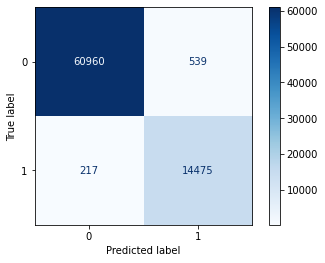

In [18]:
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, 
                            y_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))

plot_confusion_matrix(estimator=model, 
                      X=X_val, 
                      y_true=y_val, 
                      cmap='Blues'
                     )

* **Precision** - imp if we dont want a lot of false positives
* **Recall** - imp if we dont want to miss out on subscribers
    * We'll give a bit more importance to recall

In [19]:
# calculate the f2-measure

p = precision_score(y_val, 
                    y_pred)

r = recall_score(y_val, 
                 y_pred)

f = fbeta_score(y_val, 
                y_pred, 
                beta=2.0) # beta = 2 lowers the importance of precision and increase the importance of recall.

print('Result: precision=%.3f, recall=%.3f, f2-beta=%.3f' % (p, r, f))

Result: precision=0.964, recall=0.985, f2-beta=0.981


[20:31:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=1, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=60,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
                precision    recall  f1-score   support

non_subscriber       1.00      1.00      1.00     6

<AxesSubplot:>

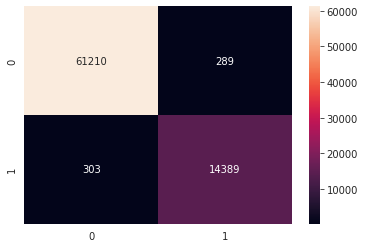

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
sns.set_style('darkgrid')

# set scale_pos_weight, max_delta_step because dataset is imbalanced 

xgb_imb = XGBClassifier(max_delta_step = 1,  
                        random_state=SEED, 
                        scale_pos_weight=2)

xgb_imb.fit(X_train, y_train)
print(xgb_imb)

xgb_imb_pred = xgb_imb.predict(X_val)

print(classification_report(y_val, xgb_imb_pred, target_names = ['non_subscriber', 'subscriber']))

# Whats going on with xgb

sns.heatmap(confusion_matrix(y_val, xgb_imb_pred), annot=True, fmt='g')

**Treatment 5** - Sampling for balancing dataset

In [21]:
print("Distribution in train set:")
print(y_train.value_counts())

Distribution in train set:
0    286992
1     68563
Name: subscription_status, dtype: int64


In [22]:
print("Distribution in val set:")
print(y_val.value_counts())

Distribution in val set:
0    61499
1    14692
Name: subscription_status, dtype: int64


* over then under - hybrid sampling

In [25]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [26]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.9) 

# first performing oversampling on minority class
X_over, y_over = over.fit_resample(X_train, y_train)

y_over = pd.Series(y_over)
print("Oversampled \n", y_over.value_counts())

# now combine undersampling 
X_combined_sampling, y_combined_sampling = under.fit_resample(X_over, y_over)

Oversampled 
 0    286992
1    143496
Name: subscription_status, dtype: int64


In [28]:
# convert back to dataframe
Xtrain_combo = pd.DataFrame(X_combined_sampling, columns = X_train.columns)
ytrain_combo = pd.Series(y_combined_sampling)

# name the series
ytrain_combo.name = "subscription_status"

print("After Combined Sampling - Distribution in train set::")

print(ytrain_combo.value_counts())

print(ytrain_combo.value_counts(normalize=True))

After Combined Sampling - Distribution in train set::
0    159440
1    143496
Name: subscription_status, dtype: int64
0   0.5
1   0.5
Name: subscription_status, dtype: float64


In [29]:
print(Xtrain_combo.shape, X_val.shape)

print("Distribution in val set:")

# distribution untouched

print(y_val.value_counts())

(302936, 51) (76191, 51)
Distribution in val set:
0    61499
1    14692
Name: subscription_status, dtype: int64


In [32]:
train_transformed = Xtrain_combo.join(ytrain_combo)
val_transformed = X_val.join(y_val)

In [36]:
BUCKET_NAME = 'bi-subscription-modeling'
BUCKET_FOLDER = 'train-val-data'

# save locally and upload .csv 
file_name = 'train_transformed_11232021.csv'

upload_csv_file(train_transformed, 
                BUCKET_NAME, 
                BUCKET_FOLDER, 
                file_name) 

# save locally and upload .csv 
file_name = 'val_transformed_11232021.csv'

upload_csv_file(val_transformed, 
                BUCKET_NAME, 
                BUCKET_FOLDER, 
                file_name) 

File uploaded to gs://bi-subscription-modeling/train-val-data/train_transformed_11232021.csv
File uploaded to gs://bi-subscription-modeling/train-val-data/val_transformed_11232021.csv


* Automatic Combination of over- and under-sampling
    * SMOTETomek
        * SMOTE - (synthetic data generation) selects examples that are close in the feature space, draws a line between the examples and draws a new sample along that line.
        * Tomek -  identifies pairs of nearest neighbors in a dataset that have different classes. Removes one or both of the examples in these pairs (such as the examples in the majority class shown below) which has the effect of making the decision boundary in the training dataset less noisy or ambiguous.
        
NOTE: Low ROI - dint pursue

In [ ]:
import time
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

st = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=SEED)

start_time = time.time()

X_res, y_res = st.fit_resample(X_train, y_train)

y_res = pd.Series(y_res)

print(y_res.value_counts()) #24mins no output

print("--- %s seconds ---" % (time.time() - start_time))